# Redes Neuronales - Aprendizaje

## Introducción

En este ejemplo, vamos a utilizar el algoritmo de backpropagation para entrenar una red neuronal en la tarea de reconocimiento de imágenes a color de 32x32 píxeles. La idea principal es ajustar los pesos de la red para minimizar la diferencia entre las salidas predichas y las etiquetas reales de las imágenes. Una vez entrenada la red, podremos utilizarla para hacer predicciones en nuevas imágenes.

In [130]:
# importamos las librerias necesarias

# calculos numericos
import numpy as np

# graficos
import matplotlib.pyplot as pyplot

# optimizacion
from scipy import optimize

# cargar archivos .mat
from scipy.io import loadmat

# lectura de archivos csv
import csv

# manejo de datos
import pandas as pd


En este ejercicio se implementará la propagación hacia atrás para entrenar una red neuronal y aprender los parámetros correspondientes.

Comenzaremos por cargar el conjunto de datos para su posterior procesamiento y entrenamiento.



In [131]:
# Configurando parametros necesario
input_layer_size = 32*32*3  # Entrada de imagenes de digitos de 32x32, 3 canales de color (RGB) (3072 pixeles)
hidden_layer_size1 = 40     # 40 neuronas ocultas primer capa
hidden_layer_size2 = 40     # 40 neuronas ocultas segunda capa
hidden_layer_size3 = 40     # 40 neuronas ocultas tercera capa
num_labels = 10             # 10 etiquetas, de 0 a 9

# link de descarga de los datasets
# https://www.cs.toronto.edu/~kriz/cifar.html => CIFAR-10 dataset
# cargamos los datos de entrenamiento
data_train1 = loadmat('data_batch_1.mat')
data_train2 = loadmat('data_batch_2.mat') 
data_train3 = loadmat('data_batch_3.mat')
data_train4 = loadmat('data_batch_4.mat')
data_train5 = loadmat('data_batch_5.mat')

# mostramos un ejempos para saber como es la estructura de los datos de los datasets
print('Dataset data_batch_1.mat => ',data_train1.keys())

# cargamos los datos de test
data_test = loadmat('test_batch.mat')
# mostramos un ejempos para saber como es la estructura de los datos del dataset de test
print('Dataset de test => ',data_test.keys())

Dataset data_batch_1.mat =>  dict_keys(['__header__', '__version__', '__globals__', 'data', 'labels', 'batch_label'])
Dataset de test =>  dict_keys(['__header__', '__version__', '__globals__', 'data', 'labels', 'batch_label'])


Una vez que hemos cargado el conjunto de datos, es importante verificar los tamaños de los conjuntos de entrenamiento (train) y prueba (test). Esto nos proporcionará información sobre la cantidad de datos que utilizaremos para entrenar y evaluar nuestro modelo.

A continuación, mostraremos los tamaños de los conjuntos de datos de entrenamiento y prueba:

In [132]:
print('-------Datos de entrenamiento-------')
# concatenamos los datos de los 5 datasets de entrenamiento en un solo dataset de entrenamiento (X_train)
X_train = data_train = np.concatenate((data_train1['data'], data_train2['data'], data_train3['data'], data_train4['data'], data_train5['data']), axis=0)
print('X shape: ',X_train.shape)
# concatenamos los datos de los 5 datasets de entrenamiento en un solo dataset de entrenamiento (y_train)
y_train = data_train = np.concatenate((data_train1['labels'], data_train2['labels'], data_train3['labels'], data_train4['labels'], data_train5['labels']), axis=0).ravel()
# reemplazamos los valores de 10 por 0
y_train[y_train == 10] = 0
print('y shape: ',y_train.shape) 
# mostramos las clases de y_train
print('y clases: ',set(y_train))

print('-------Datos de test-------')
# cargamos los datos de test (X_test)
X_test = data_test['data']
print('X shape: ',X_test.shape)
# cargamos los datos de test (y_test)
y_test = data_test['labels'].ravel()
# reemplazamos los valores de 10 por 0
y_test[y_test == 10] = 0
print('y shape: ',y_test.shape)
# mostramos las clases de y_test
print('y clases: ',set(y_test))

-------Datos de entrenamiento-------
X shape:  (50000, 3072)
y shape:  (50000,)
y clases:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
-------Datos de test-------
X shape:  (10000, 3072)
y shape:  (10000,)
y clases:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### displayData

A continuación, se proporciona una función llamada `displayData` que nos permitirá visualizar las imágenes a color del conjunto de datos. Esta función nos ayudará a entender mejor la naturaleza de las imágenes que estamos tratando y a realizar un análisis visual de los datos.

La función `displayData` toma como entrada una matriz de imágenes y muestra cada una de ellas en una cuadrícula. Cada imagen se representa como una serie de píxeles de colores que forman una imagen completa.

Utilizar esta función nos permitirá inspeccionar las imágenes de entrenamiento y prueba y obtener una idea visual de cómo son las muestras de datos con las que estamos trabajando.

A continuación se muestra el código de la función `displayData`:

In [133]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensional.')

    # Configurar ancho de ejemplo automáticamente si no se proporciona
    example_width = example_width or int(np.round(np.sqrt(n / 3)))
    example_height = int(n / (example_width * 3))

    # Calcula el número de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    # Entre cada ejemplo habrá un espacio de padding
    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    # Mostrar cada ejemplo
    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        img = X[i].reshape(example_height, example_width, 3, order='F')
        ax.imshow(img)
        ax.axis('off')

    pyplot.show()

In [134]:
# funcion para normalizar las caracteristicas entre 0 y 1
def featureNormalize(X):
    X = X/255
    return X

In [135]:
# normalizamos las X's de entrenamiento
X_train_norm = featureNormalize(X_train)
# normalizamos las X's de prueba
X_test_norm = featureNormalize(X_test)

In [136]:
# sacar el maximo valor de X_train_norm
max_value = np.max(X_train_norm)
# sacar el minimo valor de X_train_norm
min_value = np.min(X_train_norm)
print('Valor maximo de X_train_norm: ',max_value)
print('Valor minimo de X_train_norm: ',min_value)

Valor maximo de X_train_norm:  1.0
Valor minimo de X_train_norm:  0.0


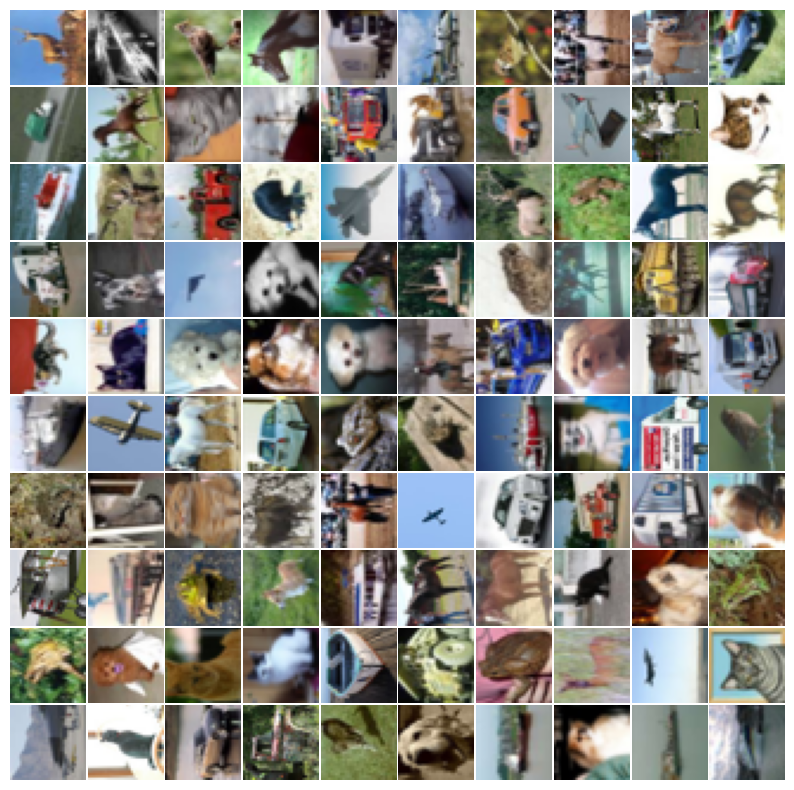

In [137]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
m = y_train.size
rand_indices = np.random.choice(m, 100, replace=False)
sel = X_train[rand_indices, :]

displayData(sel)

### checkNNGradients

La función `checkNNGradients(nnCostFunction, lambda_=0.0)` se utiliza para verificar los gradientes calculados mediante la propagación hacia atrás (backpropagation) en una red neuronal. Esta función es útil para asegurarse de que la implementación del algoritmo de backpropagation sea correcta y los gradientes se estén calculando adecuadamente.

Al llamar a la función `checkNNGradients`, se pasa como argumento la función `nnCostFunction`, que representa la función de costo utilizada en la red neuronal. Además, se puede especificar opcionalmente el parámetro `lambda_`, que corresponde al parámetro de regularización utilizado en la función de costo.

La función `checkNNGradients` calcula los gradientes analíticos mediante backpropagation y los compara con los gradientes numéricos aproximados. Si los gradientes calculados mediante backpropagation son correctos, la diferencia entre los gradientes analíticos y los numéricos debe ser muy pequeña. En caso de que haya una discrepancia significativa, esto puede indicar un error en la implementación del algoritmo de backpropagation.

In [138]:
def checkNNGradients(nnCostFunction, lambda_=0.0):
    """
    Verifica los gradientes calculados por backpropagation en una red neuronal.

    Parameters:
    - nnCostFunction: Función de costo de la red neuronal.
    - lambda_: Parámetro de regularización (por defecto es 0.0).

    Returns:
    - diff: Diferencia relativa entre los gradientes numéricos y los gradientes aproximados por backpropagation.
    """

    # Obtén los gradientes por backpropagation
    cost, grad = nnCostFunction()

    # Inicializa los gradientes numéricos
    numgrad = np.zeros_like(grad)

    # Valor pequeño para la aproximación numérica
    epsilon = 1e-4

    # Itera sobre cada parámetro en la red neuronal
    for i in range(len(grad)):
        # Aproximación numérica del gradiente
        theta_plus = np.copy(nnCostFunction.theta)
        theta_plus[i] += epsilon
        theta_minus = np.copy(nnCostFunction.theta)
        theta_minus[i] -= epsilon

        # Cálculo del costo para los parámetros theta_plus y theta_minus
        cost_plus, _ = nnCostFunction(theta_plus, lambda_)
        cost_minus, _ = nnCostFunction(theta_minus, lambda_)

        # Aproximación numérica del gradiente
        numgrad[i] = (cost_plus - cost_minus) / (2 * epsilon)

    # Calcula la diferencia relativa entre los gradientes numéricos y los gradientes por backpropagation
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)

    return diff

### Gradiente de la sigmoide

El gradiente para la función sigmoidea puede ser calculada por:

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

donde

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

#### sigmoid

La función sigmoid(z) calcula la función sigmoide de un número o una matriz, mapeando los valores a un rango entre 0 y 1 y es ampliamente utilizada en redes neuronales.

In [139]:
def sigmoid(z):
    """
    Calcula la función sigmoide de un número o una matriz.

    Parameters:
    - z: Número o matriz.

    Returns:
    - result: Resultado de aplicar la función sigmoide a z.
    """
    return 1.0 / (1.0 + np.exp(-z))

#### sigmoidGradient

La función `sigmoidGradient(z)` calcula el gradiente de la función sigmoide evaluada en `z`. Es utilizado en el proceso de backpropagation de las redes neuronales para determinar cómo cambia la función sigmoide en relación a `z`. El resultado del gradiente se utiliza para actualizar los pesos y los sesgos durante el entrenamiento del modelo.

In [140]:
def sigmoidGradient(z):
    """
    Calcula el gradiente de la función sigmoidea evaluada en z.
    Esto debería funcionar independientemente de si z es una matriz o un vector. 
    En particular, si z es un vector o una matriz, debe devolver el gradiente para cada elemento.
    """
    g = np.zeros(z.shape)
    g = sigmoid(z) * (1 - sigmoid(z))
    
    return g

### nnCostFunction

La función `nnCostFunction` implementa la función de costo y el gradiente para una red neuronal de cuatro capas que se utiliza para la clasificación. A continuación, se proporciona una descripción más detallada de los parámetros y la funcionalidad de esta función:

`nn_params`: Los parámetros de la red neuronal, que se proporcionan como un vector unidimensional.

`input_layer_size`: El tamaño de la capa de entrada de la red neuronal.

`hidden_layer_size1`, `hidden_layer_size2`, `hidden_layer_size3`: Los tamaños de las capas ocultas de la red neuronal. En este caso, se especifica que hay tres capas ocultas de diferentes tamaños.

`num_labels`: El número de etiquetas o clases en el problema de clasificación.

`X`: La matriz de características de entrada, donde cada fila representa una instancia y cada columna representa una característica.

`y`: El vector de etiquetas de entrenamiento correspondientes a las instancias de X.

`lambda_`: El parámetro de regularización (opcional) utilizado en la función de costo.

La función `nnCostFunction` calcula el costo de la red neuronal utilizando la función de costo logarítmico regularizado. También calcula el gradiente de los parámetros de la red neuronal. Este costo y gradiente se utilizan para el entrenamiento de la red neuronal mediante métodos de optimización, como el descenso del gradiente.

La función de costo para la red neuronal (sin regularización) es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

#### Funcion de costo regularizada

La implementación completa de la función `nnCostFunction` incluirá el cálculo del costo y el gradiente utilizando los parámetros de la red neuronal, las características de entrada X y las etiquetas y. Además, se aplicará la regularización si se proporciona el parámetro lambda_.

La funcion de costo para una red neuronal con regularizacion esta dado por:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{40} \sum_{k=1}^{3072} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{40} \sum_{k=1}^{40} \left( \Theta_{j,k}^{(2)} \right)^2 + \sum_{j=1}^{40} \sum_{k=1}^{40} \left( \Theta_{j,k}^{(3)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{40} \left( \Theta_{j,k}^{(4)} \right)^2 \right] $$

La red neuronal solo tendrá 5 capas: una capa de entrada, 3 capas oculta y una capa de salida. Sin embargo, el código debería funcionar para cualquier cantidad de unidades de entrada, unidades ocultas y unidades de salida. Mientras se han enumerado explícitamente los índices anteriores para $\Theta^{(1)}$, $\Theta^{(2)}$, $\Theta^{(3)}$ y $\Theta^{(4)}$ para mayor claridad, tenga en cuenta que su código debería funcionar en general con $\Theta^{(1)}$, $\Theta^{(2)}$, $\Theta^{(3)}$ y $\Theta^{(4)}$ de cualquier tamaño. Hay que tomar en cuenta que no se debe regularizar los términos que corresponden al sesgo. Para las matrices `Theta1`, `Theta2`, `Theta3` y` Theta4`, esto corresponde a la primera columna de cada matriz. 

In [141]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size1, hidden_layer_size2, hidden_layer_size3, num_labels, X, y, lambda_=0.0):
    
    # Reformar nn_params en matrices de peso Theta1, Theta2, Theta3 y Theta4
    Theta1 = nn_params[:hidden_layer_size1 * (input_layer_size + 1)].reshape(hidden_layer_size1, (input_layer_size + 1))
    start = hidden_layer_size1 * (input_layer_size + 1)
    Theta2 = nn_params[start:start + hidden_layer_size2 * (hidden_layer_size1 + 1)].reshape(hidden_layer_size2, (hidden_layer_size1 + 1))
    start += hidden_layer_size2 * (hidden_layer_size1 + 1)
    Theta3 = nn_params[start:start + hidden_layer_size3 * (hidden_layer_size2 + 1)].reshape(hidden_layer_size3, (hidden_layer_size2 + 1))
    start += hidden_layer_size3 * (hidden_layer_size2 + 1)
    Theta4 = nn_params[start:].reshape(num_labels, (hidden_layer_size3 + 1))

    # inicializar algunas variables utiles
    m = y.size
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    Theta3_grad = np.zeros(Theta3.shape)
    Theta4_grad = np.zeros(Theta4.shape)

    # retroalimentación (Feedforward)
    # Agregar una columna de unos a X para la capa de sesgo (bias) de la capa de entrada
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    # Calcular la activación de la primera capa oculta
    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    # Calcular la activación de la segunda capa oculta
    a3 = sigmoid(a2.dot(Theta2.T))
    a3 = np.concatenate([np.ones((m, 1)), a3], axis=1)
    # Calcular la activación de la tercera capa oculta
    a4 = sigmoid(a3.dot(Theta3.T))
    a4 = np.concatenate([np.ones((m, 1)), a4], axis=1)
    # Calcular la activación de la capa de salida
    a5 = sigmoid(a4.dot(Theta4.T))

    # Convertir y de (m,) a (m, num_labels)
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]

    # Inicializar variables temporales
    temp1 = Theta1
    temp2 = Theta2
    temp3 = Theta3
    temp4 = Theta4

    # Agregar el termino de regularización
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])) + np.sum(np.square(temp3[:, 1:])) + np.sum(np.square(temp4[:, 1:])))
    # Calcular el costo
    J = (-1 / m) * np.sum((np.log(a5) * y_matrix) + np.log(1 - a5) * (1 - y_matrix)) + reg_term

    # Retropropagación (Backpropagation)
    delta_5 = a5 - y_matrix
    delta_4 = delta_5.dot(Theta4)[:, 1:] * sigmoidGradient(a3.dot(Theta3.T))
    delta_3 = delta_4.dot(Theta3)[:, 1:] * sigmoidGradient(a2.dot(Theta2.T))
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))

    # Calcular degradados
    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    Delta3 = delta_4.T.dot(a3)
    Delta4 = delta_5.T.dot(a4)

    # Calcular gradientes
    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] += (lambda_ / m) * Theta1[:, 1:]
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] += (lambda_ / m) * Theta2[:, 1:]
    Theta3_grad = (1 / m) * Delta3
    Theta3_grad[:, 1:] += (lambda_ / m) * Theta3[:, 1:]
    Theta4_grad = (1 / m) * Delta4
    Theta4_grad[:, 1:] += (lambda_ / m) * Theta4[:, 1:]

    # Concatenar degradados en una sola matriz
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel(), Theta3_grad.ravel(), Theta4_grad.ravel()])

    return J, grad

#### randInitializeWeights

La función `randInitializeWeights(L_in, L_out, epsilon_init=0.12)` se utiliza para inicializar aleatoriamente los pesos de una capa en una red neuronal. Toma como argumentos el número de unidades de entrada `L_in`, el número de unidades de salida `L_out` y un parámetro opcional `epsilon_init` que controla el rango de los valores aleatorios generados.

La inicialización aleatoria de los pesos es importante para evitar que todos los pesos de la red neuronal tengan el mismo valor y permitir que los parámetros se ajusten de manera adecuada durante el proceso de entrenamiento.

Dentro de la función, se generan valores aleatorios en un rango específico, que generalmente se elige para mantener los valores iniciales de los pesos en un rango apropiado. El parámetro `epsilon_init` se utiliza para controlar este rango. Un valor comúnmente utilizado para `epsilon_init` es 0.12, pero este valor puede ajustarse según las necesidades del problema.

Los pesos se inicializan aleatoriamente dentro del rango [-epsilon_init, epsilon_init], lo que proporciona una variación inicial suficiente para permitir que el proceso de entrenamiento explore diferentes configuraciones de pesos y encuentre los valores óptimos para la red neuronal.

Esta función es útil para inicializar los pesos de manera adecuada antes de comenzar el entrenamiento de la red neuronal, lo que ayuda a mejorar la eficacia y el rendimiento del algoritmo de aprendizaje.

In [142]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Inicializar aleatoriamente los pesos de una capa en una red neuronal.
    
     Parámetros
     ----------
     L_in : int
         Número de conexiones entrantes.
    
     L_out: int
         Número de conexiones salientes.
    
     epsilon_init: flotante, opcional
         Rango de valores que puede tomar el peso de un uniforme
         distribución.
    
     Devoluciones
     -------
     W : array_like
         El peso inicializado a valores aleatorios. Tenga en cuenta que W debe
         establecerse en una matriz de tamaño (L_out, 1 + L_in) como
         la primera columna de W maneja los términos de "sesgo".
    """
    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

In [143]:
print('Inicialización de los pesos(thetas) de la red neuronal...')
"""
Utilizamos esta parte del codigo solo si no tenemos los pesos guardados

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size1)
initial_Theta2 = randInitializeWeights(hidden_layer_size1, hidden_layer_size2)
initial_Theta3 = randInitializeWeights(hidden_layer_size2, hidden_layer_size3)
initial_Theta4 = randInitializeWeights(hidden_layer_size3, num_labels)
"""
# Cargar los pesos guardados (si no existen, ejecutar la inicialización de pesos de arriba y comentar esta parte de código)
initial_Theta1 = np.loadtxt('Theta1.csv', delimiter=',')
initial_Theta2 = np.loadtxt('Theta2.csv', delimiter=',')
initial_Theta3 = np.loadtxt('Theta3.csv', delimiter=',')
initial_Theta4 = np.loadtxt('Theta4.csv', delimiter=',')

# Verificar dimensiones
print('initial_Theta1 shape: ',initial_Theta1.shape)
print('initial_Theta2 shape: ',initial_Theta2.shape)
print('initial_Theta3 shape: ',initial_Theta3.shape)
print('initial_Theta4 shape: ',initial_Theta4.shape)

# convertir los thetas(pesas) en un vector unidimensional (para usar con scipy.optimize.minimize)
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel(), initial_Theta3.ravel(), initial_Theta4.ravel()], axis=0)
# Verificar dimensiones
print('initial_nn_params shape: ',initial_nn_params.shape)

Inicialización de los pesos(thetas) de la red neuronal...
initial_Theta1 shape:  (40, 3073)
initial_Theta2 shape:  (40, 41)
initial_Theta3 shape:  (40, 41)
initial_Theta4 shape:  (10, 41)
initial_nn_params shape:  (126610,)


#### Parámetros de aprendizaje usando `scipy.optimize.minimize`

Después de haber implementado con éxito la función de costo de la red neuronal y cálculo de gradiente, el siguiente paso usaremos la minimización de `scipy` para aprender un buen conjunto de parámetros.

In [144]:
# Una vez que haya completado la tarea, cambie el maxiter a un valor mayor para ver cómo ayuda más entrenamiento.
options = {'maxfun': 50}

# También deberías probar diferentes valores de lambda
lambda_ = 0.1

# Cree una "mano abreviada" para que la función de costo se minimice
costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size1, hidden_layer_size2, hidden_layer_size3,
                                        num_labels, X_train_norm, y_train, lambda_)

# Ahora, costFunction es una función que toma solo un argumento
# (los parámetros de la red neuronal)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)
print('res: ',res)
# Obtener la solución de la optimización.
nn_params = res.x
print('nn_params shape: ',nn_params.shape)
        
# Obtener Theta1, Theta2, Theta3 y Theta4 de nn_params (solución de optimización)
Theta1 = np.reshape(nn_params[:hidden_layer_size1 * (input_layer_size + 1)],
                    (hidden_layer_size1, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size1 * (input_layer_size + 1)): 
                              (hidden_layer_size1 * (input_layer_size + 1)) + (hidden_layer_size2 * (hidden_layer_size1 + 1))],
                    (hidden_layer_size2, (hidden_layer_size1 + 1)))

Theta3 = np.reshape(nn_params[(hidden_layer_size1 * (input_layer_size + 1)) + (hidden_layer_size2 * (hidden_layer_size1 + 1)): 
                              (hidden_layer_size1 * (input_layer_size + 1)) + (hidden_layer_size2 * (hidden_layer_size1 + 1)) + (hidden_layer_size3 * (hidden_layer_size2 + 1))],
                    (hidden_layer_size3, (hidden_layer_size2 + 1)))

Theta4 = np.reshape(nn_params[(hidden_layer_size1 * (input_layer_size + 1)) + (hidden_layer_size2 * (hidden_layer_size1 + 1)) + (hidden_layer_size3 * (hidden_layer_size2 + 1)):],
                    (num_labels, (hidden_layer_size3 + 1)))

res:   message: Max. number of function evaluations reached
 success: False
  status: 3
     fun: 1.4624307533435372
       x: [ 7.746e-02  3.885e-02 ... -8.720e+00 -2.365e-01]
     nit: 6
     jac: [-3.880e-05 -9.503e-06 ...  6.179e-04  1.242e-04]
    nfev: 50
nn_params shape:  (126610,)


In [145]:
# Verificar dimensiones de los pesos (thetas)
print('Theta1 shape: ',Theta1.shape)
print('Theta2 shape: ',Theta2.shape)
print('Theta3 shape: ',Theta3.shape)
print('Theta4 shape: ',Theta4.shape)

Theta1 shape:  (40, 3073)
Theta2 shape:  (40, 41)
Theta3 shape:  (40, 41)
Theta4 shape:  (10, 41)


#### escribir_thetas_a_csv

La función `escribir_thetas_a_csv` se utiliza para guardar los pesos entrenados en un archivo CSV. Originalmente, los pesos fueron entrenados con 5000 iteraciones `(duración del entrenamiento de 2:04:26 formato HH:MM:SS)`, pero ahora, con el fin de acelerar el proceso de entrenamiento, se está utilizando un número reducido de iteraciones, en este caso, 10.

In [146]:
# funcion para crear archivos csv
def escribir_thetas_a_csv(matriz, nombre_archivo):
    with open(nombre_archivo, mode='w', newline='') as archivo_csv:
        writer = csv.writer(archivo_csv, delimiter=',')
        for fila in matriz:
            writer.writerow(fila)
    print("Los pesos entrenados se guardaron exitosamente.")

In [147]:
# Guardar los pesos (thetas) en archivos csv (para usar en la presentación del examen)
escribir_thetas_a_csv(Theta1, 'Theta1.csv')
escribir_thetas_a_csv(Theta2, 'Theta2.csv')
escribir_thetas_a_csv(Theta3, 'Theta3.csv')
escribir_thetas_a_csv(Theta4, 'Theta4.csv')

# Cargar los pesos (thetas) desde los archivos csv para verificar las dimensiones
Theta1_data = pd.read_csv('Theta1.csv', header=None)
# Obtiene las dimensiones de los pesos (Theta1)
print(Theta1_data.shape)

Theta2_data = pd.read_csv('Theta2.csv', header=None)
# Obtiene las dimensiones de los pesos (Theta2)
print(Theta2_data.shape)

Theta3_data = pd.read_csv('Theta3.csv', header=None)
# Obtiene las dimensiones de los pesos (Theta3)
print(Theta3_data.shape)

Theta4_data = pd.read_csv('Theta4.csv', header=None)
# Obtiene las dimensiones de los pesos (Theta4)
print(Theta4_data.shape)

Los pesos entrenados se guardaron exitosamente.
Los pesos entrenados se guardaron exitosamente.


Los pesos entrenados se guardaron exitosamente.
Los pesos entrenados se guardaron exitosamente.
(40, 3073)
(40, 41)
(40, 41)
(10, 41)


#### predict

La función `predict(Theta1, Theta2, Theta3, Theta4, X)` se utiliza para realizar predicciones de etiquetas utilizando una red neuronal entrenada con cuatro capas (3 capas ocultas y una de salida).

Los parámetros de la función son las matrices de pesos `Theta1, Theta2, Theta3 y Theta4`, que representan los pesos aprendidos durante el entrenamiento de la red neuronal. La matriz X contiene las características de la muestra o muestras para las cuales se desea realizar la predicción.

Al llamar a la función predict, se realiza la propagación hacia adelante en la red neuronal, pasando la entrada a través de cada capa y aplicando la función de activación correspondiente. El resultado es un vector de salida que representa las probabilidades o las predicciones de etiquetas para la entrada dada.

In [148]:
def predict(Theta1, Theta2, Theta3, Theta4, X):
    # Asegurarse de que la entrada tenga dos dimensiones
    if X.ndim == 1:
        X = X.reshape(1, -1)  # reshape a dos dimensiones

    # Variables útiles
    m = X.shape[0]
    num_labels = Theta4.shape[0]

    # inicializar la variable de retorno con ceros (indices de las clases)
    p = np.zeros(X.shape[0])
    # print("Dimensiones de p: (antes) ",p.shape)

    # Agregar una columna de unos a X para el término de sesgo (bias) de la capa de entrada
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Calcular la activación de la primera capa oculta
    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)

    # Calcular la activación de la segunda capa oculta
    a3 = sigmoid(a2.dot(Theta2.T))
    a3 = np.concatenate([np.ones((a3.shape[0], 1)), a3], axis=1)

    # Calcular la activación de la tercera capa oculta
    a4 = sigmoid(a3.dot(Theta3.T))
    a4 = np.concatenate([np.ones((a4.shape[0], 1)), a4], axis=1)

    # Calcular la activación de la capa de salida
    p = np.argmax(sigmoid(a4.dot(Theta4.T)), axis=1)
    # print("Dimensiones de p: (despues) ",p.shape)
    return p

In [149]:
train_pred = predict(Theta1, Theta2, Theta3, Theta4, X_train_norm)
print('Precisión del conjunto de entrenamiento: {:.1f}%'.format(np.mean(train_pred == y_train) * 100))
test_pred = predict(Theta1, Theta2, Theta3, Theta4, X_test_norm)
print('Precisión del conjunto de test: {:.1f}%'.format(np.mean(test_pred == y_test) * 100))

Precisión del conjunto de entrenamiento: 70.2%
Precisión del conjunto de test: 42.2%


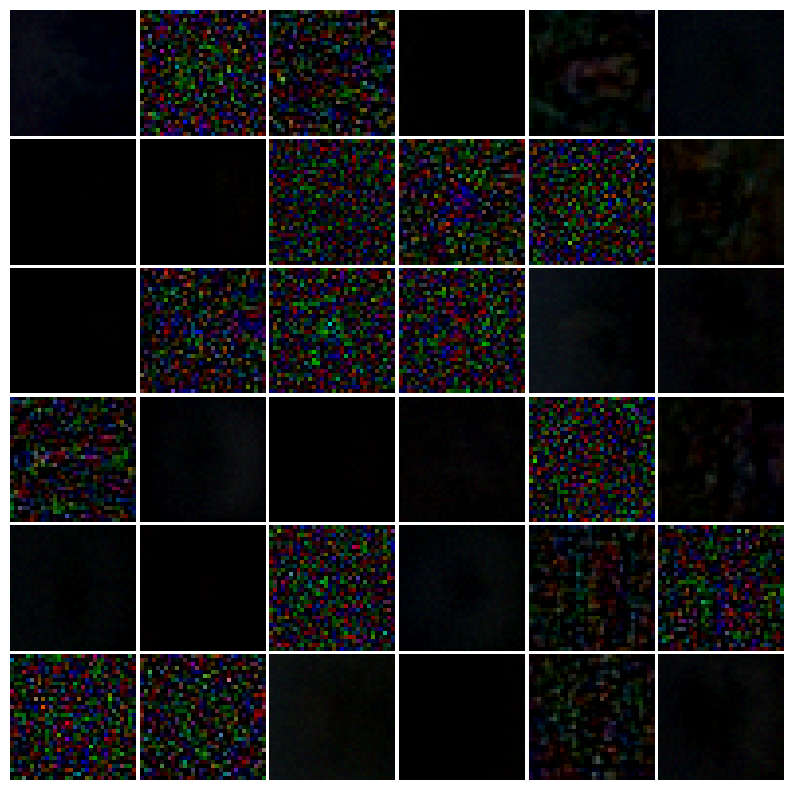

In [150]:
# Seleccionar hasta la fila 36 para visualizar los pesos de Theta1
data = Theta1[:36, 1:]
# recortar datos en el rango [0, 255] para que coincida con el formato de los datos de entrenamiento
data_clipped = np.clip(data, 0, 255)
# visualizar los pesos de Theta1
displayData(data_clipped)

#### nombreClase

La función nombreClase(y) se utiliza para asignar nombres de clase a un vector de etiquetas. Dado un vector y que contiene las etiquetas numéricas de las muestras, la función nombreClase realiza una correspondencia entre los valores numéricos y los nombres de clase correspondientes.

El propósito de esta función es proporcionar una representación más legible y comprensible de las etiquetas. En lugar de trabajar con valores numéricos, se pueden utilizar los nombres de clase asociados para una mejor interpretación y análisis de los resultados.

In [151]:
def nombreClase(y):
    """
    Convierte un vector de etiquetas en un vector de nombres de clase.
    """
    # Nombres de las clases
    nombres = ['Avión', 'Automóvil', 'Pájaro', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

    # Convierte y a una lista si no es iterable
    if not isinstance(y, (list, tuple, np.ndarray)):
        y = [y]

    # Devuelve el nombre de la clase para cada etiqueta en y
    return np.array([nombres[int(i)] for i in y])

### Pruebas

Durante las pruebas, seleccionamos una fila aleatoria de los datos de prueba, obtenemos la predicción de la red neuronal para esa imagen y mostramos en pantalla la imagen, la etiqueta real y la etiqueta predicha. Esto nos permite evaluar visualmente el rendimiento del modelo en la clasificación de imágenes.

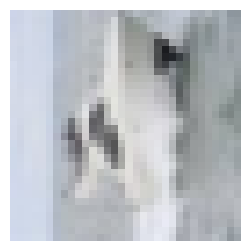

------Predicción de la red neuronal------
Etiqueta: 8
Nombre de la clase: ['Barco']
------Datos reales------
Etiqueta:  8
Nombre de la clase: ['Barco']


In [152]:
# Seleccionar una fila aleatoria de X_test
fila_test = 1205
# Mostrar la imagen
displayData(X_test[fila_test, :], figsize=(3, 3))
# Mostrar la predicción de la red neuronal
pred = predict(Theta1, Theta2, Theta3, Theta4, X_test_norm[fila_test, :])
print('------Predicción de la red neuronal------')
print('Etiqueta: {}'.format(*pred))
print('Nombre de la clase: {}'.format(nombreClase(pred)))
print('------Datos reales------')
print('Etiqueta: ', y_test[fila_test])
print('Nombre de la clase: {}'.format(nombreClase(y_test[fila_test])))

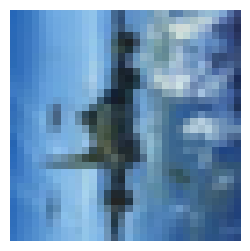

------Predicción de la red neuronal------
Etiqueta: 0
Nombre de la clase: ['Avión']
------Datos reales------
Etiqueta:  0
Nombre de la clase: ['Avión']


In [153]:
# Seleccionar una fila aleatoria de X_train
displayData(X_train[fila_test, :], figsize=(3, 3))
pred = predict(Theta1, Theta2, Theta3, Theta4, X_train_norm[fila_test, :])
print('------Predicción de la red neuronal------')
print('Etiqueta: {}'.format(*pred))
print('Nombre de la clase: {}'.format(nombreClase(pred)))
print('------Datos reales------')
print('Etiqueta: ', y_train[fila_test])
print('Nombre de la clase: {}'.format(nombreClase(y_train[fila_test])))